## The Savings Algorithm

In one picture, this is what the savings algorithm hopes to do: 

<img src=img/clark.png width="300" height="200" />


Basically the algorithm can be understood as follows: 
<ol>
  <li>Start off with a trivial solution to the problem. That is, have one vechicle travel from the depot to each node.</li>
  <li>Create a savings matrix such that s(i, j) = distance(i, depot) + distance(depot, j) - distance(i, j)</li>
  <li>Sort your savings matrix so you consider the pairs with the highest savings first</li>
  <li>Merge those nodes if </li>
</ol>         


In [8]:
import pandas as pd
import numpy  as np

# Reading Data
timedf = pd.read_csv('PrepSiteTimeMatrix.csv', nrows=41, dtype={0:int}, header=0, index_col=0)
windows = pd.read_csv('timewindows.csv', nrows=39, index_col=0)

In [9]:
prep = timedf.index.values # List of all prep sites (in prepsite matrix)
dist = [list(i) for i in list(timedf.values)] # Distance matrix as list of lists 
depot = 981 # Don't know where the warehouse is, using Evie Dennis as depot for now

In [10]:
## Building a dictionary which maps a prep site's 3 digit code to it's node in the graph
## site_to_indx[174] = 0
site_to_indx = {}
for indx, site in enumerate(prep):
    site_to_indx[site] = indx

In [11]:
## Takes two prep sites and returns the distance between them. Distances are not symetrical. 
## (174, 1109) -> 14.74
## (1109, 174) -> 15.59
def distance(i, j):
    return dist[site_to_indx[i]][site_to_indx[j]]

In [178]:
class Graph:
    prepsites = []  # A list of the prepsites 
    arcs = set()    # A set of the arcs in the graph rn
    route = {}      # Dictionary that holds lists (adjaceny list) - 0 if two nodes are not in the same route, 1 otherwise
    depot = 0       # The school code for the depot

    def __init__(self, prep, depot):
        self.prepsites = prep
        self.arcs = set()
        self.depot = depot            
        for i in prep:
            if i != depot:
                self.arcs.add((i,depot))
                self.arcs.add((depot,i))
                self.route[i] = []

    def add_arc(self, arc):
        self.arcs.add(arc)
        newroute = list(set(self.route[arc[0]] + self.route[arc[1]] + [arc[0]] + [arc[1]]))
        self.route[arc[0]] = newroute
        self.route[arc[1]] = newroute       
        for node in newroute:
            self.route[node] = newroute
            
    def remove_arc(self, arc):
        self.arcs.remove(arc)

    def is_node_interior(self, node):
        node_depot = (node, depot)
        depot_node = (depot, node)
        return not ((node_depot in self.arcs) or (depot_node in self.arcs))

    def on_same_route(self, arc):
        return arc[1] in self.route[arc[0]]

    def is_arc_interior(self, arc):
        node1 = self.is_node_interior(arc[0])
        node2 = self.is_node_interior(arc[1])
        return (not node1) and (not node2)
    
    def merge(self, arc):
        if (arc[0],depot) in self.arcs:
            if (arc[1], depot) in self.arcs:
                self.remove_arc((arc[0], depot))
                self.remove_arc((arc[1], depot))
                self.add_arc(arc)
                return
            if (depot, arc[1]) in self.arcs:
                self.remove_arc((arc[0], depot))
                self.remove_arc((depot, arc[1]))
                self.add_arc(arc)
                return
        if (depot, arc[0]) in self.arcs:
            if (arc[1], depot) in self.arcs:
                self.remove_arc((depot, arc[0]))
                self.remove_arc((arc[1], depot))
                self.add_arc(arc)
                return
            if (depot, arc[1]) in self.arcs:
                self.remove_arc((depot, arc[0]))
                self.remove_arc((depot, arc[1]))
                self.add_arc(arc)
                return   

In [179]:
## Calculates the savings from merging two prep sites i, j. 
## Using Evie Dennis as the depot, and we're assuming that distances are symetrical for now.
savings = []
for i in prep:
    if i == depot: continue
    for j in prep:
        if j == depot: continue 
        if i == j: continue 
        i_cost = distance(i, depot)
        j_cost = distance(depot, i)
        ij_cost = distance(i, j)
        save = i_cost + j_cost - ij_cost
        savings.append(((i,j), save))

In [180]:
## Sort the savings such that highest savings is on bottom
savings.sort(key=lambda tup: tup[1])

In [181]:
graph = Graph(prep, depot)
i = 0
while i<100:
    x = savings.pop()
    node1 = x[0][0]
    node2 = x[0][1]
    if not graph.is_node_interior(node1) and not graph.is_node_interior(node2):
        if not graph.on_same_route(x[0]):
            graph.merge(x[0])
    i += 1

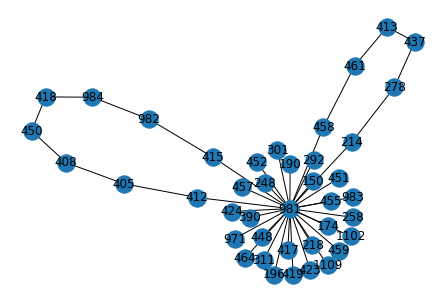

In [182]:
# libraries
import networkx as nx
import matplotlib.pyplot as plt
 
# Build the dataframe for the graph
selected_arcs = list(graph.arcs)
start = [i[0] for i in selected_arcs]
end = [i[1] for i in selected_arcs]
df = pd.DataFrame({ 'from':start, 'to':end})
 
# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')
 
 
# Plot it
nx.draw(G, with_labels=True)
plt.show()


In [183]:
graph.route

{174: [],
 1109: [],
 1102: [],
 405: [418, 450, 405, 982, 984, 408, 412, 415],
 218: [],
 461: [458, 461, 437, 278, 214, 413],
 464: [],
 214: [458, 461, 437, 278, 214, 413],
 455: [],
 278: [458, 461, 437, 278, 214, 413],
 437: [458, 461, 437, 278, 214, 413],
 413: [458, 461, 437, 278, 214, 413],
 451: [],
 458: [458, 461, 437, 278, 214, 413],
 448: [],
 417: [],
 408: [418, 450, 405, 982, 984, 408, 412, 415],
 450: [418, 450, 405, 982, 984, 408, 412, 415],
 415: [418, 450, 405, 982, 984, 408, 412, 415],
 457: [],
 452: [],
 418: [418, 450, 405, 982, 984, 408, 412, 415],
 190: [],
 292: [],
 459: [],
 150: [],
 419: [],
 248: [],
 196: [],
 258: [],
 301: [],
 390: [],
 423: [],
 424: [],
 971: [],
 982: [418, 450, 405, 982, 984, 408, 412, 415],
 983: [],
 984: [418, 450, 405, 982, 984, 408, 412, 415],
 412: [418, 450, 405, 982, 984, 408, 412, 415],
 311: []}